In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt

from keras.preprocessing.image import load_img, img_to_array, save_img
from keras.applications import vgg19
from keras import backend as K
from scipy.optimize import fmin_l_bfgs_b

In [ ]:
content_img_path = 'nature.jpg'
style_img_path = 'Pablo_Picasso.jpg'
result_prefix = 'nature_picasso'
iterations = 10

# these are the weights of the different loss components
total_variation_weight = 1.0
style_weight = 1.0
content_weight = 0.025

# dimensions of the generated picture.
width, height = load_img(content_img_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

# layer names
content_layer = 'block5_conv2'

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

In [ ]:
def preprocess_img(img_path):
    # util function to open, resize and format pictures into appropriate tensors
    img = load_img(img_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

def deprocess_img(x):
    # util function to convert a tensor into a valid image
    x = x.reshape((img_nrows, img_ncols, 3))
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68

    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

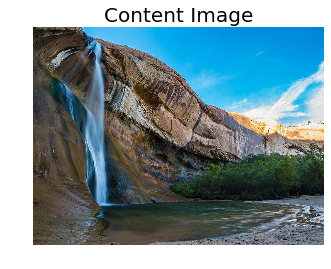

In [ ]:
plt.figure()
plt.title('Content Image', fontsize=20)
img = load_img(content_img_path)
plt.axis('off')
plt.imshow(img);

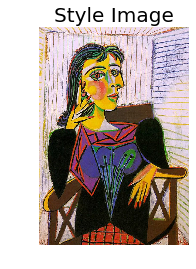

In [ ]:
plt.figure()
plt.title('Style Image', fontsize=20)
img = load_img(style_img_path)
plt.axis('off')
plt.imshow(img);

In [ ]:
# get tensor representations
content_img = K.variable(preprocess_img(content_img_path))
style_img = K.variable(preprocess_img(style_img_path))

combination_img = K.placeholder(dtype='float32', shape=(1, img_nrows, img_ncols, 3))
input_tensor = K.concatenate([content_img, style_img, combination_img], axis=0)

input_tensor.shape

TensorShape([Dimension(3), Dimension(400), Dimension(535), Dimension(3)])

In [ ]:
# get model
model = vgg19.VGG19(input_tensor=input_tensor, weights='imagenet', include_top = False)
layer_output = {layer.name: layer.output for layer in model.layers}

In [ ]:
# compute the neural style loss
# first we need to define 4 util functions
# the gram matrix of an image tensor (feature-wise outer product)
def gram_matrix(x):
    x =  K.permute_dimensions(x, (2, 0, 1))
    features = K.batch_flatten(x)
    gram = K.dot(features, K.transpose(features))
    return gram

In [ ]:
# the "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image
def style_loss(style, combination):
    width, height, channel = K.int_shape(style)
    s = gram_matrix(style)
    c = gram_matrix(combination)
    loss = K.sum(K.square(s - c)) # / (4.0 * channel**2 * ((width * height)**2))
    return loss

In [ ]:
# an auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image
def content_loss(content, combination):
    return K.sum(K.square(combination - content))


In [ ]:
# the 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent
def total_variation_loss(x):
    i = K.square(x[:, :-1, :-1, :] - x[:, 1:, :-1, :])
    j = K.square(x[:, :-1, :-1, :] - x[:, :-1, 1:, :])
    loss = K.sum(K.pow(i+j, 1.25))
    return loss

In [ ]:
# combine these loss functions into a single scalar
loss = K.variable(0.)
# content loss
layer_features = layer_output[content_layer]
content_feature = layer_features[0, :, :, :]
combination_feature = layer_features[2, :, :, :]
loss += content_weight * content_loss(content_feature, combination_feature)

# style loss
for layer_name in style_layers:
    layer_features = layer_output[layer_name]
    style_feature = layer_features[1, :, :, :]
    combination_feature = layer_features[2, :, :, :]
    sl = style_loss(style_feature, combination_feature)
    loss += style_weight * sl / len(style_layers)
   

# total variation loss
loss += total_variation_weight * total_variation_loss(content_img)

In [ ]:
# get the gradients of the generated image wrt the loss
grads = K.gradients(loss, combination_img)[0]
fetch_grads_loss = K.function([combination_img], [loss, grads])

def eval_grads_loss(x):
    x = x.reshape((1, img_nrows, img_ncols, 3))
    loss_value, grads_values = fetch_grads_loss([x])
    grads_values = grads_values.flatten().astype('float64')
    return loss_value, grads_values

In [ ]:
# this Evaluator class makes it possible
# to compute loss and gradients in one pass
# while retrieving them via two separate functions,
# "loss" and "grads". This is done because scipy.optimize
# requires separate functions for loss and gradients,
# but computing them separately would be inefficient.

class Evaluator:
    def __init__(self):
        self.loss_value = None
        self.grads_values = None
    def loss(self, x):
        assert self.loss_value is None
        self.loss_value ,self.grads_values = eval_grads_loss(x)
        return self.loss_value
    def grads(self, x):
        self.loss_value = None
        return self.grads_values
evaluator = Evaluator()

In [ ]:
# run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss
x = preprocess_img(content_img_path)

for i in range(iterations):
    print(f'Start of iteration {i}')
    start_time = time.time()

    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.grads, maxfun=20)
    img = deprocess_img(x.copy())
    name = result_prefix + f'_at_iteration_{i}.jpg'
    save_img(name, img)
    print(f'Image saved as {name}')
    end_time = time.time()
    print(f'Iteration {i} completed in {end_time - start_time:.0f}')

Start of iteration 0
Image saved as nature_picasso_at_iteration_0.jpg
Iteration 0 completed in 21
Start of iteration 1
Image saved as nature_picasso_at_iteration_1.jpg
Iteration 1 completed in 14
Start of iteration 2
Image saved as nature_picasso_at_iteration_2.jpg
Iteration 2 completed in 15
Start of iteration 3
Image saved as nature_picasso_at_iteration_3.jpg
Iteration 3 completed in 14
Start of iteration 4
Image saved as nature_picasso_at_iteration_4.jpg
Iteration 4 completed in 15
Start of iteration 5
Image saved as nature_picasso_at_iteration_5.jpg
Iteration 5 completed in 15
Start of iteration 6
Image saved as nature_picasso_at_iteration_6.jpg
Iteration 6 completed in 15
Start of iteration 7
Image saved as nature_picasso_at_iteration_7.jpg
Iteration 7 completed in 15
Start of iteration 8
Image saved as nature_picasso_at_iteration_8.jpg
Iteration 8 completed in 15
Start of iteration 9
Image saved as nature_picasso_at_iteration_9.jpg
Iteration 9 completed in 15


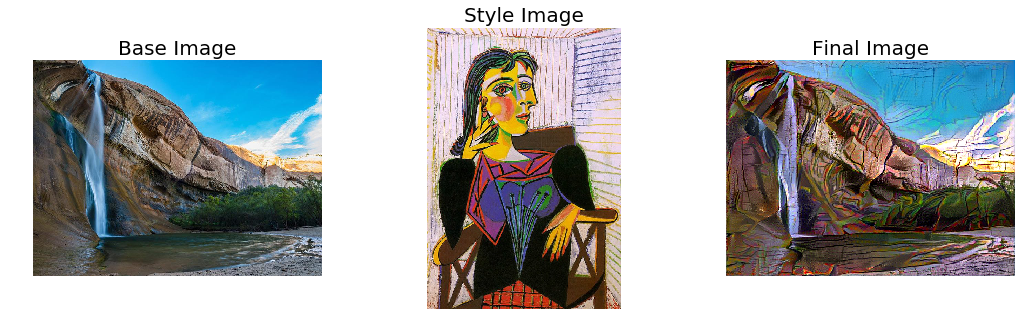

In [ ]:
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
plt.title("Base Image",fontsize=20)
img_content = load_img(content_img_path)
plt.axis('off')
plt.imshow(img_content)

plt.subplot(5,5,1+1)
plt.title("Style Image",fontsize=20)
img_style = load_img(style_img_path)
plt.axis('off')
plt.imshow(img_style)

plt.subplot(5,5,1+2)
plt.title("Final Image",fontsize=20)
plt.axis('off')
plt.imshow(deprocess_img(x.copy()))